In [38]:
import os
import sys

print("os.getcwd():", os.getcwd())

# 1) Try to detect if we are in the project root (has 'src' and 'notebooks')
if os.path.isdir("src") and os.path.isdir("notebooks"):
    PROJECT_ROOT = os.getcwd()
    print("Detected PROJECT_ROOT as current directory (has src/ and notebooks/).")
# 2) Or if we are inside notebooks/ folder
elif os.path.basename(os.getcwd()) == "notebooks" and os.path.isdir("../src"):
    PROJECT_ROOT = os.path.abspath("..")
    print("Detected PROJECT_ROOT as parent of notebooks/.")
else:
    # Fallback: assume current dir is project root
    PROJECT_ROOT = os.getcwd()
    print("Fallback PROJECT_ROOT (please check):", PROJECT_ROOT)

# Make sure Python can import src/
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

print("Final PROJECT_ROOT:", PROJECT_ROOT)

# Build ABSOLUTE paths
DATA_DIR    = os.path.join(PROJECT_ROOT, "notebooks", "data")
MODELS_ROOT = os.path.join(PROJECT_ROOT, "notebooks", "models")
RESULTS_DIR = os.path.join(PROJECT_ROOT, "notebooks", "results")

print("DATA_DIR   :", DATA_DIR)
print("MODELS_ROOT:", MODELS_ROOT)
print("RESULTS_DIR:", RESULTS_DIR)

# Diagnostics: does notebooks/models exist? What is inside?
print("Exists MODELS_ROOT?:", os.path.isdir(MODELS_ROOT))
if os.path.isdir(MODELS_ROOT):
    print("Content of MODELS_ROOT:", os.listdir(MODELS_ROOT))
else:
    print("WARNING: MODELS_ROOT does not exist at this path.")



os.getcwd(): /Users/malakmaher/Documents/GitHub/Emotion-Recognition/notebooks
Detected PROJECT_ROOT as parent of notebooks/.
Final PROJECT_ROOT: /Users/malakmaher/Documents/GitHub/Emotion-Recognition
DATA_DIR   : /Users/malakmaher/Documents/GitHub/Emotion-Recognition/notebooks/data
MODELS_ROOT: /Users/malakmaher/Documents/GitHub/Emotion-Recognition/notebooks/models
RESULTS_DIR: /Users/malakmaher/Documents/GitHub/Emotion-Recognition/notebooks/results
Exists MODELS_ROOT?: True
Content of MODELS_ROOT: ['run_2025-12-07_02-26-01', 'run_2025-12-07_03-06-47', 'run_2025-12-07_01-50-26', 'run_2025-12-07_02-22-47', 'run_2025-12-12_22-49-52']


In [39]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report
from src.data_loader import load_train_val_test


In [40]:
import glob

def get_latest_run(models_root=MODELS_ROOT):
    run_dirs = sorted(
        glob.glob(os.path.join(models_root, "run_*")),
        reverse=True
    )
    print("Found run dirs:", run_dirs)
    if not run_dirs:
        raise FileNotFoundError(f"No run_* folders found under {models_root}")
    return run_dirs[0]

latest_run = get_latest_run()
print("Using run folder:", latest_run)

best_model_path = os.path.join(latest_run, "best_model.h5")
history_path    = os.path.join(latest_run, "history.json")

print("Best model path :", best_model_path)
print("History path    :", history_path)


Found run dirs: ['/Users/malakmaher/Documents/GitHub/Emotion-Recognition/notebooks/models/run_2025-12-12_22-49-52', '/Users/malakmaher/Documents/GitHub/Emotion-Recognition/notebooks/models/run_2025-12-07_03-06-47', '/Users/malakmaher/Documents/GitHub/Emotion-Recognition/notebooks/models/run_2025-12-07_02-26-01', '/Users/malakmaher/Documents/GitHub/Emotion-Recognition/notebooks/models/run_2025-12-07_02-22-47', '/Users/malakmaher/Documents/GitHub/Emotion-Recognition/notebooks/models/run_2025-12-07_01-50-26']
Using run folder: /Users/malakmaher/Documents/GitHub/Emotion-Recognition/notebooks/models/run_2025-12-12_22-49-52
Best model path : /Users/malakmaher/Documents/GitHub/Emotion-Recognition/notebooks/models/run_2025-12-12_22-49-52/best_model.h5
History path    : /Users/malakmaher/Documents/GitHub/Emotion-Recognition/notebooks/models/run_2025-12-12_22-49-52/history.json


In [41]:
# use detected latest run directory
RUN_DIR = latest_run

model = load_model(os.path.join(RUN_DIR, "best_model.h5"))

# pass DATA_DIR (no duplicate/path concatenation that can cause type errors)
X_train, X_val, X_test, y_train, y_val, y_test, labels = load_train_val_test(
    DATA_DIR
)

Loaded X: (2781, 128, 128, 1)
Loaded y: (2781,)
Train: X=(1946, 128, 128, 1), y=(1946, 8)
Val:   X=(417, 128, 128, 1), y=(417, 8)
Test:  X=(418, 128, 128, 1), y=(418, 8)


14/14 [==============================] - 1s 34ms/step


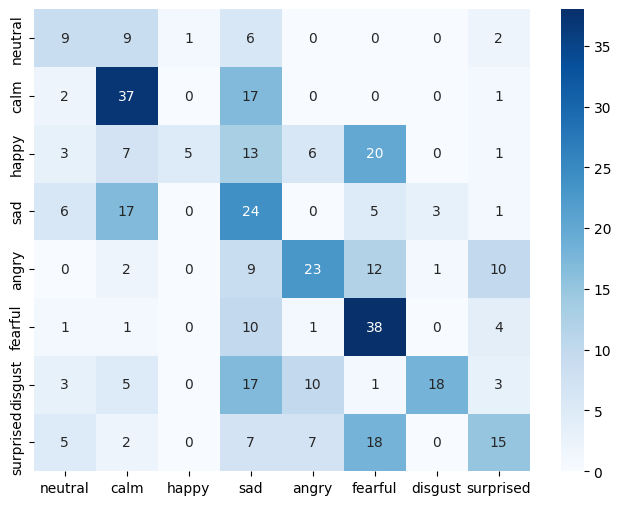

In [42]:
y_true = np.argmax(y_test, axis=1)
y_pred = np.argmax(model.predict(X_test), axis=1)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, cmap="Blues",
            xticklabels=labels,
            yticklabels=labels)
plt.savefig("results/confusion_matrix.png", dpi=300)
plt.show()


In [43]:
report = classification_report(y_true, y_pred, target_names=labels)

# ensure results directory exists and write the report there
os.makedirs(RESULTS_DIR, exist_ok=True)
report_path = os.path.join(RESULTS_DIR, "classification_report.txt")
with open(report_path, "w") as f:
    f.write(report)

print(report)

              precision    recall  f1-score   support

     neutral       0.31      0.33      0.32        27
        calm       0.46      0.65      0.54        57
       happy       0.83      0.09      0.16        55
         sad       0.23      0.43      0.30        56
       angry       0.49      0.40      0.44        57
     fearful       0.40      0.69      0.51        55
     disgust       0.82      0.32      0.46        57
   surprised       0.41      0.28      0.33        54

    accuracy                           0.40       418
   macro avg       0.49      0.40      0.38       418
weighted avg       0.51      0.40      0.39       418



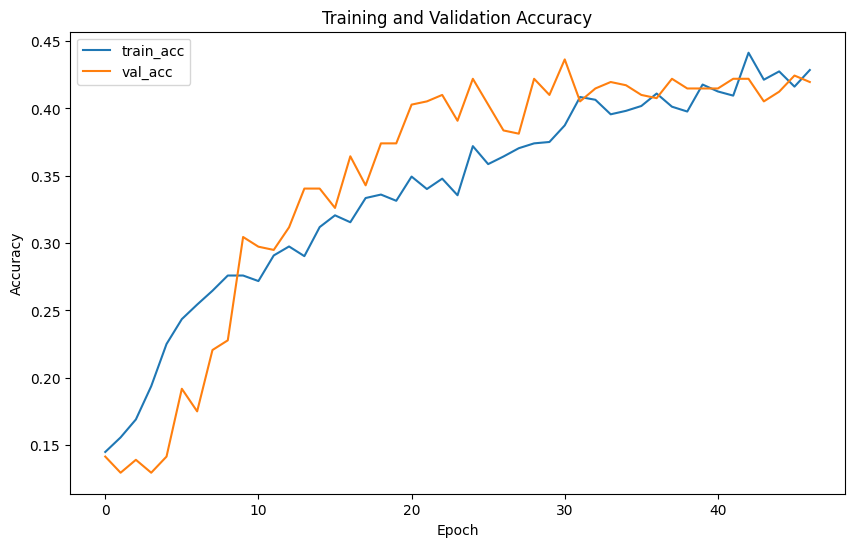

In [44]:
try:
    with open(os.path.join(RUN_DIR, "history.json")) as f:
        history = json.load(f)
except json.JSONDecodeError as e:
    print(f"Error loading history.json: {e}")
    print("The JSON file may be corrupted. Attempting to load with error recovery...")
    with open(os.path.join(RUN_DIR, "history.json")) as f:
        content = f.read()
    # Try to find and fix common JSON issues
    content = content.rstrip(',')  # Remove trailing commas
    history = json.loads(content)

# Ensure results directory exists
os.makedirs(RESULTS_DIR, exist_ok=True)

plt.figure(figsize=(10, 6))
plt.plot(history["accuracy"], label="train_acc")
plt.plot(history["val_accuracy"], label="val_acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training and Validation Accuracy")
plt.savefig(os.path.join(RESULTS_DIR, "training_curves.png"), dpi=300)
plt.show()

In [45]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=labels))


              precision    recall  f1-score   support

     neutral       0.31      0.33      0.32        27
        calm       0.46      0.65      0.54        57
       happy       0.83      0.09      0.16        55
         sad       0.23      0.43      0.30        56
       angry       0.49      0.40      0.44        57
     fearful       0.40      0.69      0.51        55
     disgust       0.82      0.32      0.46        57
   surprised       0.41      0.28      0.33        54

    accuracy                           0.40       418
   macro avg       0.49      0.40      0.38       418
weighted avg       0.51      0.40      0.39       418

